In [1]:
import numpy as np
from matplotlib import pyplot as plt
from enum import IntEnum
from itertools import islice
from IPython.display import clear_output

ModuleNotFoundError: No module named 'numpy'

In [ ]:
class var(IntEnum):
    freq, mag_db, ph_deg = range(3)

In [ ]:
# Data interpolation Enable.
iterpEnable = True
N_points = 10000
Ri = 20

In [ ]:
file_list = ['uncoated', 'coated']
N = len(file_list)
import_data = np.empty(N, dtype=object)
for n, file_name in enumerate(file_list):
    import_data[n] = np.loadtxt('AP300/' + file_name + '.dat', skiprows=1)
    # Data descaling.
    import_data[n][:,var.mag_db.value] += 20*np.log10(Ri)
    import_data[n][:,var.ph_deg.value] = np.unwrap(import_data[n][:,var.ph_deg.value]*np.pi/180 + np.pi)*180/np.pi

In [ ]:
data = np.empty(N, dtype=object)
for n in range(N):
    if iterpEnable:
        data[n] = np.zeros((N_points, len(var)))
        data[n][:,var.freq.value] = np.logspace(np.log10(min(import_data[n][:,var.freq.value])),
                                                np.log10(max(import_data[n][:,var.freq.value])),
                                                N_points)
        for k in islice(var, var.mag_db.value, None):
            data[n][:,k.value] = np.interp(data[n][:,var.freq.value],
                                            import_data[n][:,var.freq.value],
                                            import_data[n][:,k.value])
    else:
        data[n] = import_data[n].copy()

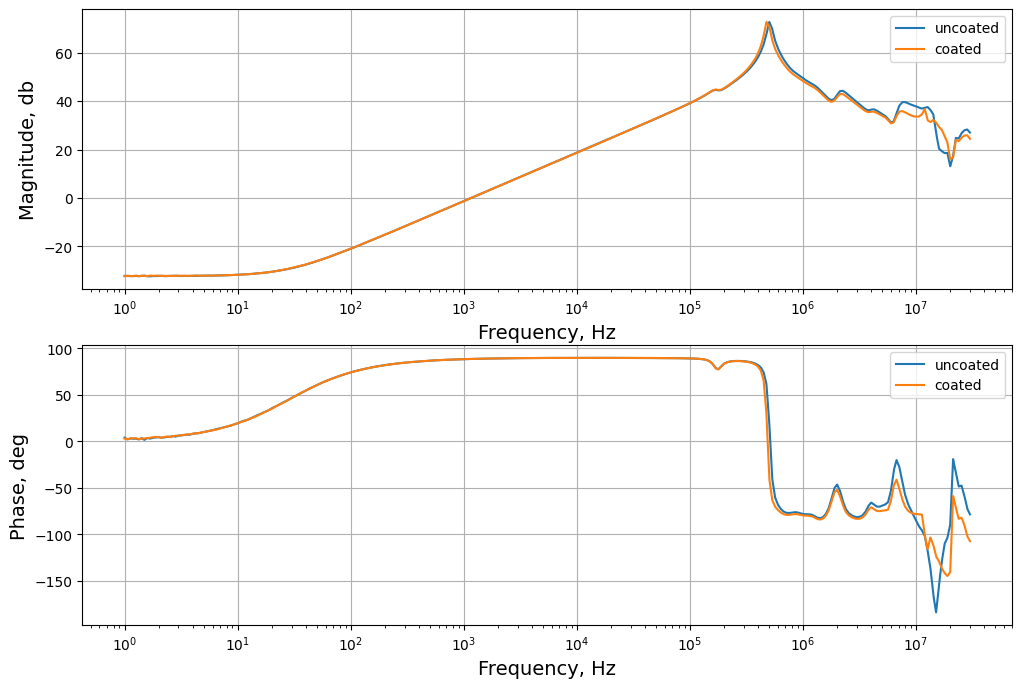

In [ ]:
user_fontsize = 14
user_ylabel = ['Magnitude, db', 'Phase, deg']
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
for idx in range(2):
    ax = axes[idx]
    for n in range(N):
        ax.plot(data[n][:, var.freq.value], data[n][:, idx + 1], label=file_list[n])
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylabel(user_ylabel[idx], fontsize=user_fontsize)
    ax.grid(True)

plt.savefig('readme_img/measured_freq_resp.png', bbox_inches='tight')
plt.show()

In [ ]:
def reactor_model(freq, L, r, C, R):
    s = 1j * 2 * np.pi * freq

    # Complex gain.
    gain_comp = (1 /(s*C) * (r + s*L) / (1 /(s*C) + (r + s*L)) * R) / (1 /(s*C) * (r + s*L) / (1 /(s*C) + (r + s*L)) + R)
    
    # Magnitude.
    gain_abs = 20*np.log10(np.abs(gain_comp))
    gain_phase = np.unwrap(np.angle(gain_comp))*180/np.pi

    return [gain_abs, gain_phase]

In [ ]:
# Parameters.
r = [0.025, 0.025]
L = [136e-6, 136e-6]
C = [725e-12, 800e-12]
R = [6e3, 6e3]

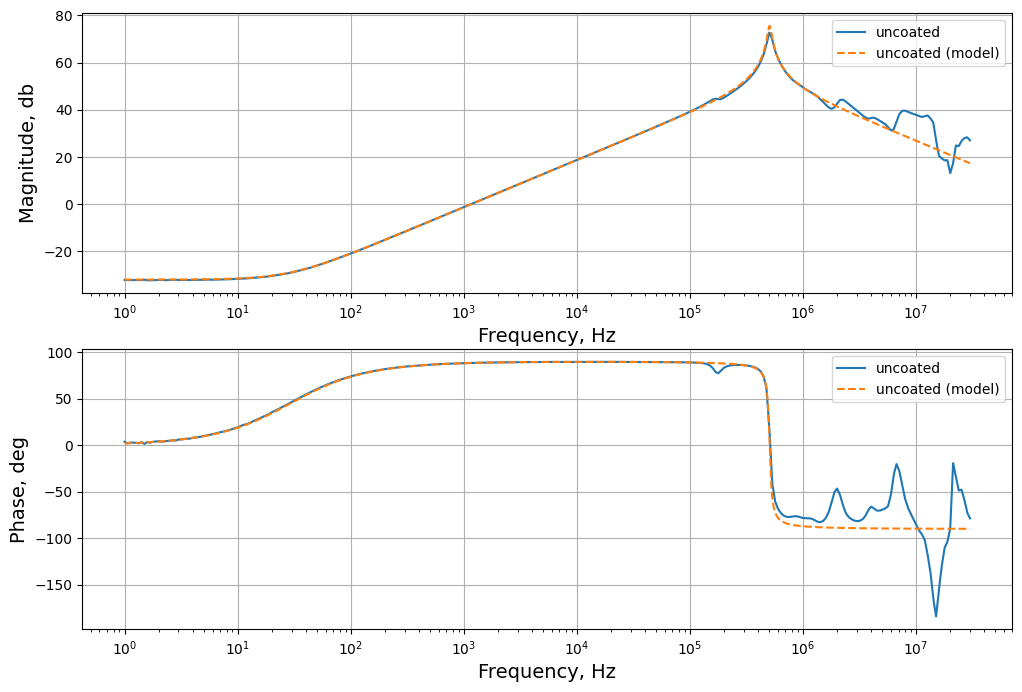

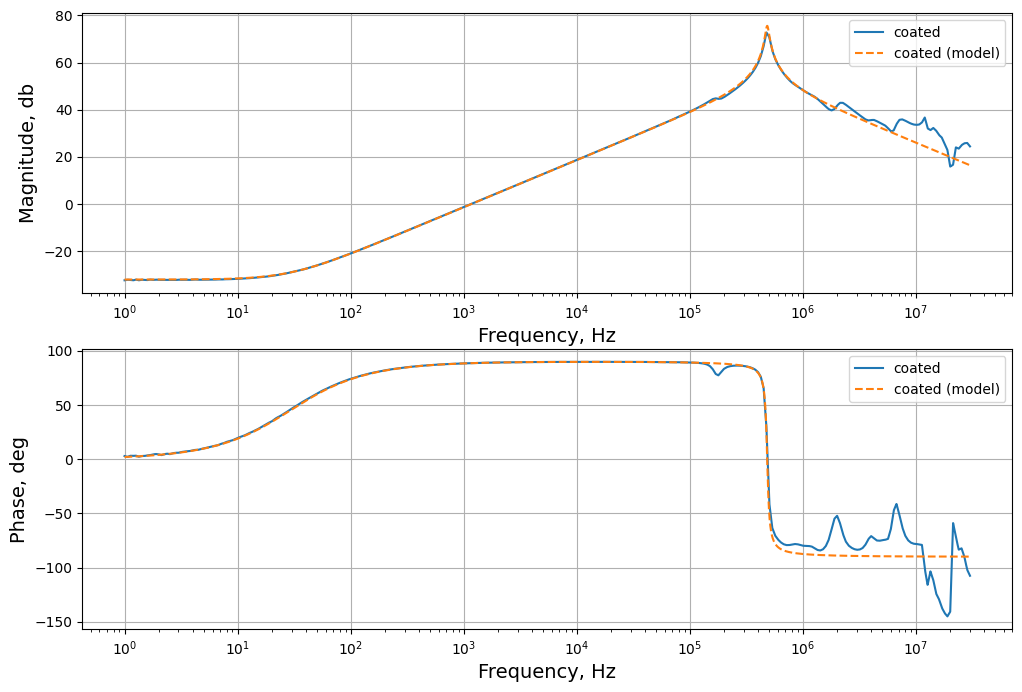

In [ ]:

for n, file_name in enumerate(file_list):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    abs_phase_dataset = reactor_model(data[n][:, var.freq.value], L[n], r[n], C[n], R[n])
    for idx in range(2):
        axs[idx].plot(data[n][:, var.freq.value], data[n][:, idx + 1], label=file_name)
        axs[idx].plot(data[n][:, var.freq.value], abs_phase_dataset[idx], '--', label=file_name + ' (model)')
        axs[idx].set_xlabel('Frequency, Hz', fontsize=user_fontsize)
        axs[idx].set_ylabel(user_ylabel[idx], fontsize=user_fontsize)
        axs[idx].axes.grid(True)
        axs[idx].set_xscale('log')
        axs[idx].legend()
    plt.show()

Амплитудная характеристика принята в качестве отклика.

In [ ]:
# freq - частоты.
# y - эталон.
def loss_func(freq, y, w_coeff):
    L = w_coeff[0,0]
    r = w_coeff[0,1]
    C = w_coeff[0,2]
    #R = w_coeff[0,3]

    [abs_dataset, _] = reactor_model(freq, L, r, C)#, R)

    # Функция возвращает сумму квадратов отклонений наблюдений от эталона.
    return np.sum((y - abs_dataset)**2)